In [1]:
import pandas as pd, wntr, matplotlib.pyplot as plt, copy, plotly

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）

In [3]:
#读取管径方案表
df = pd.read_excel('方案.xlsx',index_col=0)
#管径为0表示在该方案中无该管道

In [4]:
# 读取inp文件
wn = wntr.network.WaterNetworkModel('BASIC.INP') # 获取管网模型

In [5]:
# 读取方案，生成模型
watermodel = {}
for i in df:
    watermodel[i] = copy.deepcopy(wn)
    for j in df[i].index:
        if df.loc[j, i] == 0:
            watermodel[i].links[j].initial_status = 'Closed'
        else:
            watermodel[i].links[j].diameter = df.loc[j, i]/1000
    #watermodel[i].write_inpfile(f'{i}.inp') # 输出模型为inp文件

In [6]:
res = {}
# 模拟计算各个方案
for key, v in watermodel.items():
    res[key] = wntr.sim.EpanetSimulator(v).run_sim()
    #res[key].link.to_excel(f'{key}-link.xlsx') # 将结果按照方案输出为excel（管段数据）
    #res[key].node.to_excel(f'{key}-node.xlsx') # 将结果按照方案输出为excel（节点数据）

In [7]:
# 计算结果可用参数列表
PARAMETERS = {'link':['flowrate', 'headloss', 'linkquality', 'status', 'velocity'],'node':['demand', 'head', 'pressure', 'quality']}

In [8]:
# 将结果保存为容易横向对比的数据结构
data = {}
for i, l in PARAMETERS.items():
    for key in l:
        temp = {}
        for index, value in res.items():
            if i == 'link':
                temp[index] = value.link[key]
            else:
                temp[index] = value.node[key]
        data[key] = pd.Panel(temp)
        del temp
        #data[key].to_excel(f'{key}.xlsx') # 将结果按照参数输出为excel

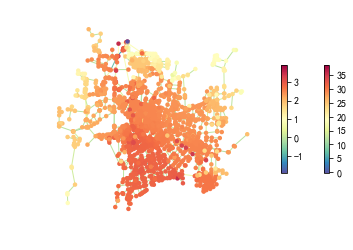

In [9]:
#管网压力图绘制
pressure_at_1hr = res['方案1'].node['pressure'].loc[25200,:]
flowrate_at_1hr = res['方案1'].link['flowrate'].loc[3600,:]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_1hr, 
                        link_attribute=flowrate_at_1hr)

plt.show()

In [10]:
df2 = pd.read_excel('报告设置.xlsx')

In [11]:
#根据报告表生成图表
for i in df2.index:
    data[df2.loc[i,'参数']][:,:,df2.loc[i,'ID']].plot(figsize=(8,5),title=f'{df2.loc[i,"ID"]}-{df2.loc[i,"参数"]}曲线图')
    plt.savefig(f'{df2.loc[i,"ID"]}-{df2.loc[i,"参数"]}曲线图')# 将曲线图保存为图片文件

In [12]:
#根据报告生成报表
report = pd.DataFrame()
for i in df2.index:
    temp = data[df2.loc[i,'参数']][:,:,df2.loc[i,'ID']]
    temp['ID'] = df2.loc[i,'ID']
    temp['参数'] = df2.loc[i,'参数']
    report = report.append(temp)
report.set_index(['ID','参数',report.index], inplace=True)
report.sort_index(inplace=True)
report.to_excel('报告.xlsx')

In [185]:
# 管网压力图绘制2
pressure_at_1hr = res['方案1'].node['pressure'].loc[25200,:]
wntr.graphics.network.plot_interactive_network(wn,figsize=[1200,800],node_attribute=pressure_at_1hr,node_range=[20,35])

In [182]:
# 多方案但时间多点对比
data['pressure'][:,25200,df2[df2.参数.isin(PARAMETERS['node'])].ID]

,方案1,方案2,方案3,现状
name,,,,
JGS009,32.271469,32.236332,32.212513,32.465431
Y007,28.481464,28.648821,28.785479,27.251841
Y099,28.715569,28.981808,29.116289,27.747696
Y029,21.612076,21.903883,22.089075,20.652937


In [13]:
# 多方案单节点对比
data['flowrate'][:,:,'PIPE01']

,方案1,方案2,方案3,现状
0,1.032755,1.073977,1.115136,0.0
3600,0.928433,0.961796,1.001138,0.0
7200,0.891745,0.922503,0.961348,0.0
10800,0.883708,0.913623,0.953173,0.0
14400,0.891964,0.918746,0.963188,0.0
18000,1.227000,1.281664,1.325039,0.0
21600,1.586845,1.666748,1.711655,0.0
25200,1.899799,1.983095,2.048271,0.0
28800,1.857696,1.935860,2.003956,0.0
32400,1.628663,1.708138,1.759217,0.0


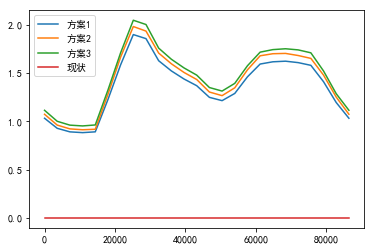

In [17]:
# 绘制曲线图
data['flowrate'][:,:,'PIPE01'].plot()
plt.show()